In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import torch
from scipy.ndimage.filters import gaussian_filter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

In [2]:
import keras
from keras import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv3D, MaxPooling3D, UpSampling3D, Concatenate, Reshape, Dense, Lambda, Flatten, BatchNormalization
from skimage.transform import rotate
from keras import backend as K
from keras import optimizers
from mpl_toolkits import mplot3d
import h5py
from keras import applications

Using TensorFlow backend.
/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/zhaohongjin/anaconda3/lib/pytho

In [4]:
def readh5(filename, datasetname='main', rr=[1,1,1]):
    fid=h5py.File(filename,'r')
    if isinstance(datasetname, (list,)):
        out = [None] *len(datasetname)
        for i,dd in enumerate(datasetname):
            sz = len(fid[dd].shape)
            if sz==2:
                out[i] = np.array(fid[dd][::rr[0],::rr[1]])
            elif sz==3:
                out[i] = np.array(fid[dd][::rr[0],::rr[1],::rr[2]])
    else:
        sz = len(fid[datasetname].shape)
        if sz==2:
            out = np.array(fid[datasetname][::rr[0],::rr[1]])
        elif sz==3:
            out = np.array(fid[datasetname][::rr[0],::rr[1],::rr[2]])
        elif sz==4:
            out = np.array(fid[datasetname][::,::rr[0],::rr[1],::rr[2]])
    return out


def writeh5(filename, dtarray, datasetname='main'): 
    fid=h5py.File(filename,'w')                                                                      
    if isinstance(datasetname, (list,)):                                                             
        for i,dd in enumerate(datasetname):                                                          
            ds = fid.create_dataset(dd, dtarray[i].shape, compression="gzip", dtype=dtarray[i].dtype)
            ds[:] = dtarray[i]                                                                       
    else:                                                                                            
        ds = fid.create_dataset(datasetname, dtarray.shape, compression="gzip", dtype=dtarray.dtype) 
        ds[:] = dtarray                                                                              
    fid.close()

# 1. Generate polynomials

Here we use fourth degree polynomials $ax^{4} + bx^{3} + cx^{2} + dx + e$

In [12]:
def f(x, p):
    """
    p = [a, b, c, d, e]
    """
    return p[0]*x**4 + p[1]*x**3 + p[2]*x**2 + p[3]*x + p[4]

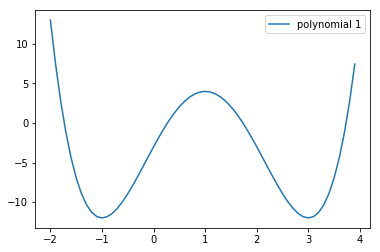

In [13]:
x = np.arange(-2, 4, 0.1)
fx1 = f(x, [1, -4, -2, 12, -3])

plt.plot(x, fx1, label="polynomial 1")
plt.legend()
plt.show()

# 2. Using B-splines to fit the sample points

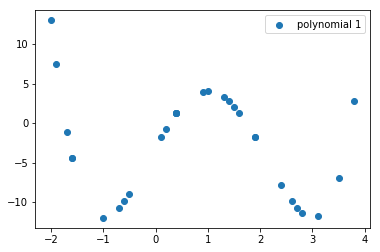

In [14]:
x_sample = np.random.choice(x, 30)
fx1_sample = f(x_sample, [1, -4, -2, 12, -3])

plt.scatter(x_sample, fx1_sample, label="polynomial 1")
plt.legend()
plt.show()

In [18]:
x

array([-2.00000000e+00, -1.90000000e+00, -1.80000000e+00, -1.70000000e+00,
       -1.60000000e+00, -1.50000000e+00, -1.40000000e+00, -1.30000000e+00,
       -1.20000000e+00, -1.10000000e+00, -1.00000000e+00, -9.00000000e-01,
       -8.00000000e-01, -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
       -4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
        1.77635684e-15,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
        4.00000000e-01,  5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
        8.00000000e-01,  9.00000000e-01,  1.00000000e+00,  1.10000000e+00,
        1.20000000e+00,  1.30000000e+00,  1.40000000e+00,  1.50000000e+00,
        1.60000000e+00,  1.70000000e+00,  1.80000000e+00,  1.90000000e+00,
        2.00000000e+00,  2.10000000e+00,  2.20000000e+00,  2.30000000e+00,
        2.40000000e+00,  2.50000000e+00,  2.60000000e+00,  2.70000000e+00,
        2.80000000e+00,  2.90000000e+00,  3.00000000e+00,  3.10000000e+00,
        3.20000000e+00,  

In [19]:
fx1.shape

(60,)

t: [-2.00000000e+00 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00
 -1.80000000e+00 -1.70000000e+00 -1.60000000e+00 -1.50000000e+00
 -1.40000000e+00 -1.30000000e+00 -1.20000000e+00 -1.10000000e+00
 -1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
 -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -3.00000000e-01
 -2.00000000e-01 -1.00000000e-01  1.77635684e-15  1.00000000e-01
  2.00000000e-01  3.00000000e-01  4.00000000e-01  5.00000000e-01
  6.00000000e-01  7.00000000e-01  8.00000000e-01  9.00000000e-01
  1.00000000e+00  1.10000000e+00  1.20000000e+00  1.30000000e+00
  1.40000000e+00  1.50000000e+00  1.60000000e+00  1.70000000e+00
  1.80000000e+00  1.90000000e+00  2.00000000e+00  2.10000000e+00
  2.20000000e+00  2.30000000e+00  2.40000000e+00  2.50000000e+00
  2.60000000e+00  2.70000000e+00  2.80000000e+00  2.90000000e+00
  3.00000000e+00  3.10000000e+00  3.20000000e+00  3.30000000e+00
  3.40000000e+00  3.50000000e+00  3.60000000e+00  3.70000000e+00
  3.90000000e+00  3.90

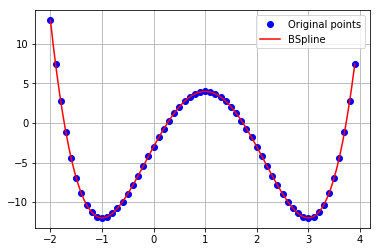

In [7]:
# k Degree 3 Beizer curves
t, c, k = interpolate.splrep(x, fx1, s=0, k=3)
print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

plt.plot(x, fx1, 'bo', label='Original points')
plt.plot(xx, spline(xx), 'r', label='BSpline')
plt.grid()
plt.legend(loc='best')
plt.show()

# 3. Generate Dataset to feed in VAE or U-Net

(1) Generate 100 random high degree polynomials. 

(2) points -> graph: Create 100 * 100 numpy matrices for training data. Each point is treated as a pixel.

(3) Create Gaussian blending on the graph

In [10]:
def generate_polynomials(n, xrange, loc, scale, degree):
    """
    n: number of polynomials
    xrange: [lowerbound, upperbound]
    loc: mu
    scale: sigma
    degree: the degree of polynomial
    """
    X = np.zeros((n, xrange.shape[0]))
    for i in range(n):
        p = np.poly1d(np.random.normal(loc=loc, scale=scale, size=degree+1))
        # Randomly generate coefficients for the polynomial.
        X[i] = np.minimum(np.abs(p(xrange)*3), xrange.shape[0]-1).astype("int64")
    return X

def generate_image(X):
    """
    convert 2-D points to 2-D images
    """
    image = np.zeros((X.shape[0], X.shape[1], X.shape[1]))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            image[i, j, int(X[i, j])] = 1.0
    return image

In [213]:
xrange = np.arange(-1, 1, 0.02)
polynomials = generate_polynomials(10000, xrange, 0, 10, 6)
X = np.expand_dims(generate_image(polynomials), axis=1)
y = gaussian_filter(X, sigma=[0, 0, 2, 2])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

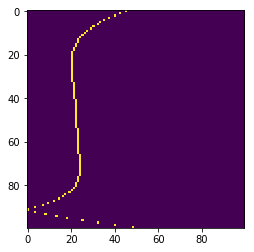

In [214]:
plt.imshow(X_train[350, 0])

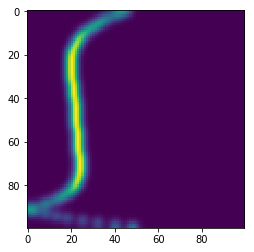

In [215]:
plt.imshow(y_train[350,0])

# 4. Apply VAE

In [195]:
class VAE(nn.Module):
    def __init__(self, in_channel=1, out_channel=1, img_size=(100, 100), latent_size=256):
        super(VAE, self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.img_size = img_size
        self.latent_size = latent_size
        
        # Encoder
        self.conv1 = nn.Conv2d(in_channel, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)
        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(25 * 25 * 16, latent_size)
        self.fc_bn1 = nn.BatchNorm1d(latent_size)
        self.fc21 = nn.Linear(latent_size, latent_size)
        self.fc22 = nn.Linear(latent_size, latent_size)
        # Sampling vector
        self.fc3 = nn.Linear(latent_size, latent_size)
        self.fc_bn3 = nn.BatchNorm1d(latent_size)
        self.fc4 = nn.Linear(latent_size, 25 * 25 * 16)
        self.fc_bn4 = nn.BatchNorm1d(25 * 25 * 16)
        # Decoder
        self.conv5 = nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, out_channel, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 16*25*25)
        
        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))
        mu = self.fc21(fc1)
        std = self.fc22(fc1)
        
        std = std.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        z = eps.mul(std).add_(mu)
        
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 25, 25)
        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        out = self.conv8(conv7).view(-1, self.out_channel, self.img_size[0], self.img_size[1])
        
        return(out, mu, std)


class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
        
    def weighted_mse_loss(self, inputs, targets, w):
        return (((inputs-targets) * w) **2).mean()
    
    def forward(self, recon_x, x, mu, logvar, w):
        MSE = self.weighted_mse_loss(recon_x, x, w)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2)-logvar.exp())
        return MSE + KLD

In [196]:
batch_size = 128

net = VAE()
net = net.double()

criterion = VAELoss()

train = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))

trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

testloader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

optimizer = optim.Adam(net.parameters(), lr=0.001)

In [197]:
for epoch in range(10):  # loop over the dataset multiple times
    print("epoch: ", epoch)

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # weights
        alpha = 100
        w = torch.tensor((inputs.detach().numpy() > 0) * alpha, dtype=torch.double)

        # forward + backward + optimize
        out, mu, std = net(inputs)
        loss = criterion(out, labels, mu, std, w)
        loss.backward()
        optimizer.step()
        
        # print statistics
        if i % 10 == 0:
            print("loss:", loss.item())

print('Finished Training')

epoch:  0
loss: 13372.81237840999
loss: 6607.065043694624
loss: 3506.1495870680824
loss: 2079.6651292601778
loss: 1302.742080697025
loss: 908.1097886952249
epoch:  1
loss: 684.0561660831945
loss: 543.8426432846231
loss: 449.14097640459505
loss: 357.22855160433943
loss: 298.00397175136817
loss: 260.66272468451047
epoch:  2
loss: 238.0556538781113
loss: 200.4355778477366
loss: 174.98112072073442
loss: 154.11703722673838
loss: 140.5855487151901
loss: 133.1674475640426
epoch:  3
loss: 113.77820284419398
loss: 105.17680687445335
loss: 98.47891946800394
loss: 91.53750718547845
loss: 78.94996060179524
loss: 72.84068849409617
epoch:  4
loss: 76.8779687112563
loss: 64.37414883709671
loss: 59.19449489131418
loss: 55.30494932150006
loss: 52.76851346904969
loss: 51.36647240633907
epoch:  5
loss: 46.08123304899104
loss: 43.28780604889309
loss: 42.5354076337491
loss: 40.20539376286827
loss: 39.30382534205682
loss: 34.44042678126739
epoch:  6
loss: 32.75837715174631
loss: 32.89301038374197
loss: 29.7

In [198]:
dataiter = iter(testloader)
images, labels = dataiter.next()

out, mu, std  = net(images)

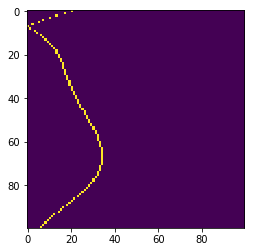

In [199]:
plt.imshow(images[20,0])

In [200]:
out = out.detach().numpy()

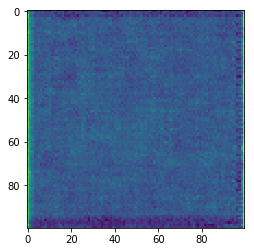

In [201]:
plt.imshow(out[0,0])

In [4]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet_model(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_squared_error', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

# 5. VAE with Keras to Complete 2D Points

In [5]:
def define_encoder_block(x, num_filters):  
    """
    Todo: Define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
          Also define a 2D max pooling layer (MaxPooling2D) (you can keep default arguments).
    """
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = MaxPooling2D()(x)
    return x

def define_decoder_block(x, num_filters):
    """
    Todo: Define one 2D upsampling layer (UpSampling2D) (you can keep default arguments).
          Also, define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
    """
    x = UpSampling2D()(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    return x

def define_net(variational, height, width, channel, batch_size, latent_dim, conditioning_dim=0,
               start_filters=8,):
    """Defines a (variational) encoder-decoder architecture.
    
    Args:
        variational: Whether a variational autoencoder should be defined.
        height: The height of the image input and output.
        width: The width of the image input and output.
        channel: Number of channels of the image.
        batch_size: The batchsize that is used during training. Must also be used for inference on the encoder side.
        latent_dim: The dimension of the latent space.
        conditioning_dim: The dimension of the space of variables to condition on. Can be zero for an unconditional VAE.
        start_filters: The number of filters to start from. Multiples of this value are used across the network. Can be used
            to change model capacity.
        
    Returns:
        Tuple of keras models for full VAE, encoder part and decoder part only.
    """
    
    # Prepare the inputs.
    inputs = Input((height, width, channel))
    if conditioning_dim > 0:
        # Define conditional VAE. Note that this is usually not the preferred way
        # of incorporating the conditioning information in the encoder.
        condition = Input([conditioning_dim])
        condition_up = Dense(height * width)(condition)
        condition_up = Reshape([height, width, 1])(condition_up)
        inputs_new = Concatenate(axis=3)([inputs, condition_up])
    else:
        inputs_new = inputs
    
    # Define the encoder.
    eblock1 = define_encoder_block(inputs_new, start_filters)
    eblock2 = define_encoder_block(eblock1, start_filters*2)
    eblock3 = define_encoder_block(eblock2, start_filters*4)
    eblock4 = define_encoder_block(eblock3, start_filters*8)
    _, *shape_spatial = eblock4.get_shape().as_list()
    eblock4_flat = Flatten()(eblock4)
    
    if not variational:
        z = Dense(latent_dim)(eblock4_flat)
    else:
        # Perform the sampling.
        def sampling(args):
            """Samples latent variable from a normal distribution using the given parameters."""
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
            return z_mean + K.exp(z_log_sigma) * epsilon
        
        z_mean = Dense(latent_dim)(eblock4_flat)
        z_log_sigma = Dense(latent_dim)(eblock4_flat)
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    if conditioning_dim > 0:
        z_ext = Concatenate()([z, condition])

    # Define the decoder.
    inputs_embedding = Input([latent_dim + conditioning_dim])
    embedding = Dense(np.prod(shape_spatial), activation='relu')(inputs_embedding)
    embedding = Reshape(eblock4.shape.as_list()[1:])(embedding)
        
    dblock1 = define_decoder_block(embedding, start_filters*8)
    dblock2 = define_decoder_block(dblock1, start_filters*4)
    dblock3 = define_decoder_block(dblock2, start_filters*2)
    dblock4 = define_decoder_block(dblock3, start_filters)
    output = Conv2D(channel, 1, activation = 'tanh')(dblock4)
    
    # Define the models.
    decoder = Model(input = inputs_embedding, output = output)
    if conditioning_dim > 0:
        encoder_with_sampling = Model(input = [inputs, condition], output = z)
        encoder_with_sampling_ext = Model(input = [inputs, condition], output = z_ext)
        vae_out = decoder(encoder_with_sampling_ext([inputs, condition]))
        vae = Model(input = [inputs, condition], output = vae_out)
    else:
        encoder_with_sampling = Model(input = inputs, output = z)
        vae_out = decoder(encoder_with_sampling(inputs))
        vae = Model(input = inputs, output = vae_out)
    
    # Define the VAE loss.
    def vae_loss(x, x_decoded_mean):
        """Defines the VAE loss functions as a combination of MSE and KL-divergence loss."""
        mse_loss = K.mean(keras.losses.mse(x, x_decoded_mean), axis=(1,2)) * height * width
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return mse_loss + kl_loss
    
    if variational:
        vae.compile(loss=vae_loss, optimizer='adam')
    else:
        vae.compile(loss='mse', optimizer='adam')    
        
    print('done,', vae.count_params(), 'parameters.')
    return vae, encoder_with_sampling, decoder

In [35]:
xrange = np.linspace(-1, 1, 128)
polynomials = generate_polynomials(10000, xrange, 0, 10, 6)
X = np.expand_dims(generate_image(polynomials), axis=3)
y = gaussian_filter(X, sigma=[0, 2, 2, 0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [76]:
vae, encoder, decoder = define_net(
    True, 128, 128, 1, batch_size=50, latent_dim=10, start_filters=4)

/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:110: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_54:0", shape=(?, 128, 128, 1), dtype=float32) at layer "input_54". The following previous layers were accessed without issue: []

In [113]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_355 (Conv2D)             (None, 128, 128, 4)  40          input_50[0][0]                   
__________________________________________________________________________________________________
conv2d_356 (Conv2D)             (None, 128, 128, 4)  148         conv2d_355[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_97 (MaxPooling2D) (None, 64, 64, 4)    0           conv2d_356[0][0]                 
__________________________________________________________________________________________________
conv2d_357

In [22]:
#vae.fit(X_train, y_train, batch_size=50, verbose=1, epochs=2)

In [417]:
vae.save("2DVAE.h5")

In [415]:
y_predict2 = vae.predict(X_train, batch_size=50)

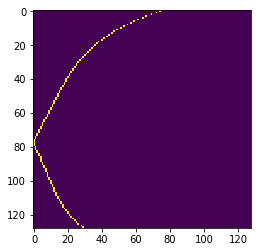

In [412]:
plt.imshow(X_train[150, :, :, 0])

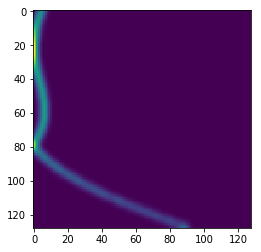

In [329]:
plt.imshow(y_train[10, :, :, 0])

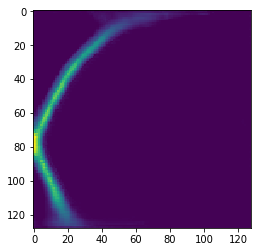

In [416]:
plt.imshow(y_predict2[150, :, :, 0])

# VAE to complete junction points

In [6]:
#X = readh5("SK-LARGE-test-train.h5")
#y = readh5("SK-LARGE-test-labels.h5")
X = readh5("SK-LARGE-pred.h5")
y = readh5("SK-LARGE-test.h5")
X, y = np.expand_dims(X, 4), np.expand_dims(y, 4)
# Image augmentation
X_horizontal_flip = X[:, :, ::-1, :]
y_horizontal_flip = y[:, :, ::-1, :]
X_vertical_flip = X[:, ::-1, :, :]
y_vertical_flip = y[:, ::-1, :, :]

X_vertical_flip = np.concatenate((X_horizontal_flip, X_vertical_flip), axis=0)
X = np.concatenate((X, X_vertical_flip), axis=0)
X = X / 255

y_vertical_flip = np.concatenate((y_horizontal_flip, y_vertical_flip), axis=0)
y = np.concatenate((y, y_vertical_flip), axis=0)

/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


In [6]:
X.shape

(2238, 256, 256, 1)

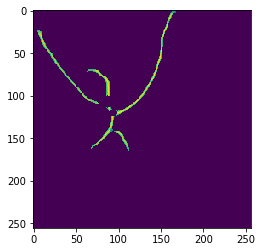

In [7]:
plt.imshow(X[2][:,:,0])

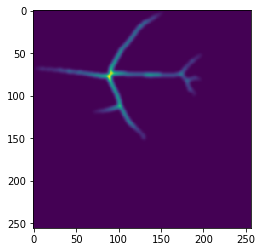

In [98]:
plt.imshow(y[188, :, :, 0])

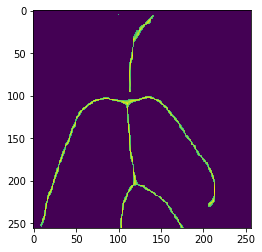

In [99]:
plt.imshow(X_train[188, :, :, 0])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.09, random_state=42)

In [223]:
X_train.shape

(2036, 256, 256, 1)

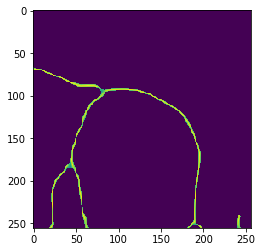

In [101]:
plt.imshow(X_train[1001][:,:,0])

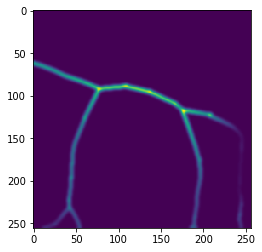

In [102]:
plt.imshow(y_train[1001][:,:,0])

In [8]:
unet = unet_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [13]:
vae, encoder, decoder = define_net(
    True, 256, 256, 1, batch_size=4, latent_dim=50, start_filters=4)

done, 1283165 parameters.


/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`
/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`


In [15]:
vae.fit(X_train*10, y_train, batch_size=4, verbose=1, epochs=10)

Epoch 1/10
2036/2036 [==============================] - 188s 92ms/step - loss: 37181.2941
Epoch 2/10
2036/2036 [==============================] - 192s 94ms/step - loss: 36199.5386
Epoch 3/10
2036/2036 [==============================] - 187s 92ms/step - loss: 35361.1829
Epoch 4/10
2036/2036 [==============================] - 188s 92ms/step - loss: 34780.1090
Epoch 5/10
2036/2036 [==============================] - 192s 94ms/step - loss: 34287.2598
Epoch 6/10
2036/2036 [==============================] - 192s 94ms/step - loss: 33835.7692
Epoch 7/10
2036/2036 [==============================] - 192s 94ms/step - loss: 33505.7895
Epoch 8/10
2036/2036 [==============================] - 197s 97ms/step - loss: 33201.6132
Epoch 9/10
2036/2036 [==============================] - 212s 104ms/step - loss: 32879.3832
Epoch 10/10
2036/2036 [==============================] - 216s 106ms/step - loss: 32737.1956


In [30]:
unet.fit(X_train*10, y_train, batch_size=4, verbose=1, epochs=2)

Epoch 1/2


KeyboardInterrupt: 

In [297]:
X_test.shape

(202, 256, 256, 1)

In [12]:
y_test_pred = unet.predict(X_test[:4], batch_size=4)

In [107]:
y_train_pred = vae.predict(X_train[:36], batch_size=12)

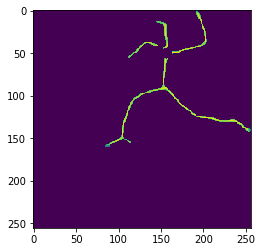

In [26]:
plt.imshow(X_test[3][:,:,0] * 10)

In [313]:
np.average(X_test[20][:,:,0] * 10)

0.19692155426623772

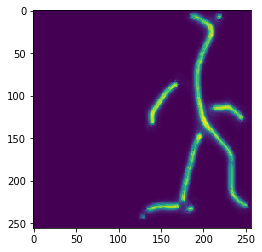

In [28]:
plt.imshow(y_test_pred[2][:,:,0])

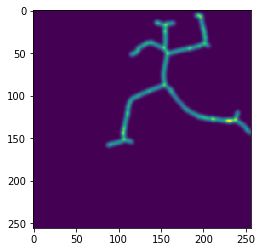

In [24]:
plt.imshow(y_test[3][:,:,0])

In [314]:
np.average(y_test[20][:,:,0])

0.2694613257117454

In [260]:
y_pred = vae.predict(X_train[:200], batch_size=4)

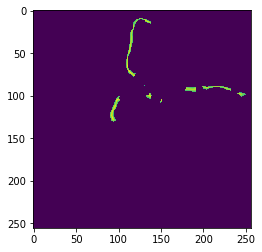

In [291]:
plt.imshow(X_train[199][:,:,0])

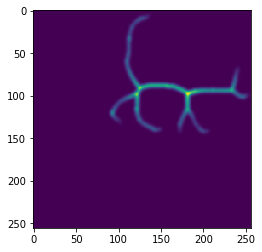

In [292]:
plt.imshow(y_train[199][:,:,0])

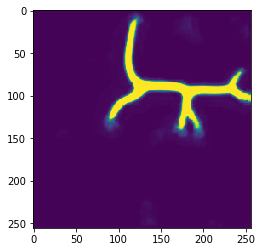

In [293]:
plt.imshow(y_pred[199][:,:,0])

# 6. Generate 3D points 

In [361]:
def generate_polynomials_3d(n, trange, loc, scale, degree):
    """
    n: number of polynomials
    trange: [lowerbound, upperbound]
    loc: mu
    scale: sigma
    degree: the degree of polynomial
    """
    X = np.zeros((n, 3, trange.shape[0]))
    for i in range(n):
        px = np.poly1d(np.random.normal(loc=loc, scale=scale, size=degree+1))
        py = np.poly1d(np.random.normal(loc=loc, scale=scale, size=degree+1))
        pz = np.poly1d(np.random.normal(loc=loc, scale=scale, size=degree+1))
        # Randomly generate coefficients for the polynomial.
        X[i][0] = np.minimum(np.abs(px(trange)*3), trange.shape[0]-1).astype("int64")
        X[i][1] = np.minimum(np.abs(py(trange)*3), trange.shape[0]-1).astype("int64")
        X[i][2] = np.minimum(np.abs(pz(trange)*3), trange.shape[0]-1).astype("int64")

    return X

def generate_image_3d(X):
    """
    convert 3-D points to 3-D images
    """
    image = np.zeros((X.shape[0], X.shape[2], X.shape[2], X.shape[2]))
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            image[i, int(X[i, 0, j]), int(X[i, 1, j]), int(X[i, 2, j])] = 1.0
    return image

In [420]:
trange = np.linspace(-1, 1, 128)
polynomials = generate_polynomials_3d(200, trange, 0, 10, 6)
image = generate_image_3d(polynomials)
X = np.expand_dims(generate_image_3d(polynomials), axis=5)
y = gaussian_filter(X, sigma=[0, 2, 2, 2, 0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


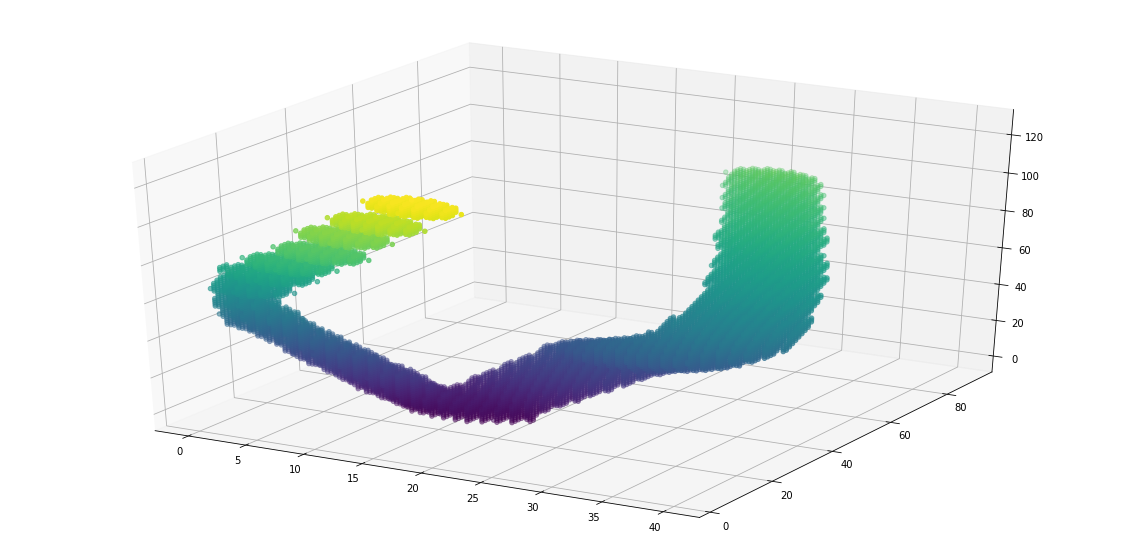

In [393]:
indexes = np.argwhere(y[0, :, :, :, 0] > 0.001)

fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

zdata = indexes[:, 0]
xdata = indexes[:, 1]
ydata = indexes[:, 2]
ax.scatter3D(xdata, ydata, zdata, c=zdata)

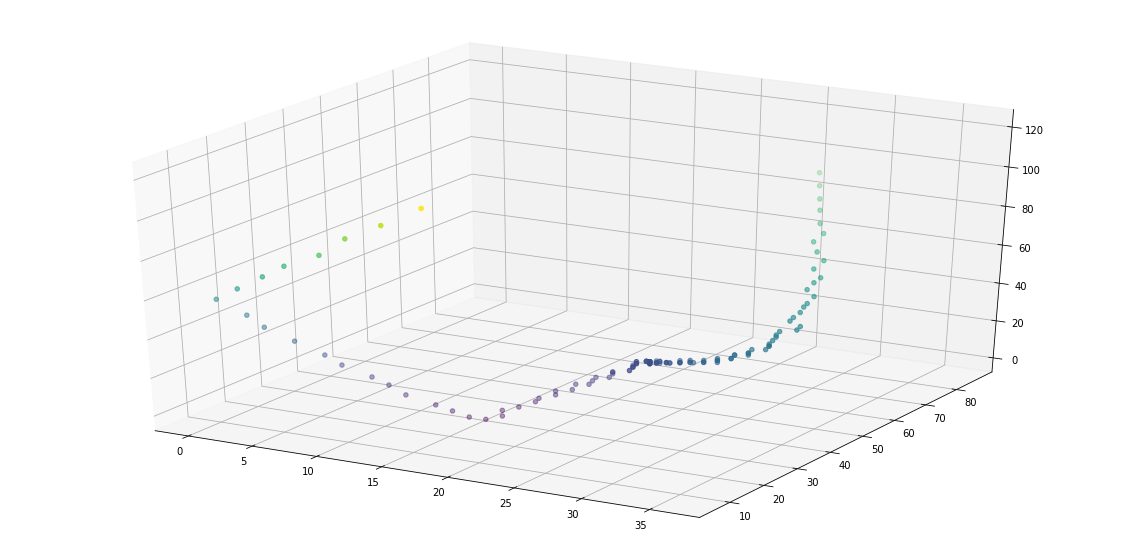

In [381]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

zdata = polynomials[0, 0]
xdata = polynomials[0, 1]
ydata = polynomials[0, 2]
ax.scatter3D(xdata, ydata, zdata, c=zdata)

# 7. VAE with Keras to generate 3D points

In [422]:
def define_encoder_block(x, num_filters):  
    """
    Todo: Define two sequential 3D convolutional layers (Conv3D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
          Also define a 3D max pooling layer (MaxPooling3D) (you can keep default arguments).
    """
    x = Conv3D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv3D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = MaxPooling3D()(x)
    return x

def define_decoder_block(x, num_filters):
    """
    Todo: Define one 3D upsampling layer (UpSampling3D) (you can keep default arguments).
          Also, define two sequential 3D convolutional layers (Conv3D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
    """
    x = UpSampling3D()(x)
    x = Conv3D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = Conv3D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    return x

def define_net(variational, height, width, depth, channel, batch_size, latent_dim, conditioning_dim=0,
               start_filters=8,):
    """Defines a (variational) encoder-decoder architecture.
    
    Args:
        variational: Whether a variational autoencoder should be defined.
        height: The height of the image input and output.
        width: The width of the image input and output.
        channel: Number of channels of the image.
        batch_size: The batchsize that is used during training. Must also be used for inference on the encoder side.
        latent_dim: The dimension of the latent space.
        conditioning_dim: The dimension of the space of variables to condition on. Can be zero for an unconditional VAE.
        start_filters: The number of filters to start from. Multiples of this value are used across the network. Can be used
            to change model capacity.
        
    Returns:
        Tuple of keras models for full VAE, encoder part and decoder part only.
    """
    
    # Prepare the inputs.
    inputs = Input((height, width, depth, channel))
    if conditioning_dim > 0:
        # Define conditional VAE. Note that this is usually not the preferred way
        # of incorporating the conditioning information in the encoder.
        condition = Input([conditioning_dim])
        condition_up = Dense(height * width * depth)(condition)
        condition_up = Reshape([height, width, depth, 1])(condition_up)
        inputs_new = Concatenate(axis=3)([inputs, condition_up])
    else:
        inputs_new = inputs
    
    # Define the encoder.
    eblock1 = define_encoder_block(inputs_new, start_filters)
    eblock2 = define_encoder_block(eblock1, start_filters*2)
    eblock3 = define_encoder_block(eblock2, start_filters*4)
    eblock4 = define_encoder_block(eblock3, start_filters*8)
    _, *shape_spatial = eblock4.get_shape().as_list()
    eblock4_flat = Flatten()(eblock4)
    
    if not variational:
        z = Dense(latent_dim)(eblock4_flat)
    else:
        # Perform the sampling.
        def sampling(args):
            """Samples latent variable from a normal distribution using the given parameters."""
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
            return z_mean + K.exp(z_log_sigma) * epsilon
        
        z_mean = Dense(latent_dim)(eblock4_flat)
        z_log_sigma = Dense(latent_dim)(eblock4_flat)
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    if conditioning_dim > 0:
        z_ext = Concatenate()([z, condition])

    # Define the decoder.
    inputs_embedding = Input([latent_dim + conditioning_dim])
    embedding = Dense(np.prod(shape_spatial), activation='relu')(inputs_embedding)
    embedding = Reshape(eblock4.shape.as_list()[1:])(embedding)
        
    dblock1 = define_decoder_block(embedding, start_filters*8)
    dblock2 = define_decoder_block(dblock1, start_filters*4)
    dblock3 = define_decoder_block(dblock2, start_filters*2)
    dblock4 = define_decoder_block(dblock3, start_filters)
    output = Conv3D(channel, 1, activation = 'tanh')(dblock4)
    
    # Define the models.
    decoder = Model(input = inputs_embedding, output = output)
    if conditioning_dim > 0:
        encoder_with_sampling = Model(input = [inputs, condition], output = z)
        encoder_with_sampling_ext = Model(input = [inputs, condition], output = z_ext)
        vae_out = decoder(encoder_with_sampling_ext([inputs, condition]))
        vae = Model(input = [inputs, condition], output = vae_out)
    else:
        encoder_with_sampling = Model(input = inputs, output = z)
        vae_out = decoder(encoder_with_sampling(inputs))
        vae = Model(input = inputs, output = vae_out)
    g
    # Define the VAE loss.
    def vae_loss(x, x_decoded_mean):
        """Defines the VAE loss functions as a combination of MSE and KL-divergence loss."""
        mse_loss = K.mean(keras.losses.mse(x, x_decoded_mean), axis=(1,2,3)) * height * width * depth
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return mse_loss + kl_loss

    if variational:
        vae.compile(loss=vae_loss, optimizer='adam')
    else:
        vae.compile(loss='mse', optimizer='adam')    
        
    print('done,', vae.count_params(), 'parameters.')
    return vae, encoder_with_sampling, decoder

In [430]:
vae3d, encoder3d, decoder3d = define_net(
    True, 128, 128, 128, 1, batch_size=10, latent_dim=10, start_filters=4)

done, 645653 parameters.


/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`
/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`


In [431]:
vae3d.fit(X_train, y_train, batch_size=10, verbose=1, epochs=10)

Epoch 1/10


KeyboardInterrupt: 

In [25]:
import scipy.io
pwd = 'Connectomics/SK-LARGE/groundTruth/train/'

skeletons = []

import os

directory = os.fsencode(pwd)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    mat = scipy.io.loadmat(directory + file)
    skeleton = mat['symmetry']
    skeletons.append(skeleton)

# Limit the size of the image to (250, 250)
max_x, max_y = 250, 250

# Padding each image to the max shape
for i in range(len(skeletons)):
    skeleton_pad = np.zeros((max_x, max_y))
    skeleton = skeletons[i]
    M, N = min(max_x, skeleton.shape[0]), min(max_y, skeleton.shape[1])
    for m in range(M):
        for n in range(N):
            skeleton_pad[m][n] = skeleton[m][n]

    skeleton_pad = np.expand_dims(skeleton_pad, axis=0)
    skeletons[i] = skeleton_pad

skeleton_meta = [] # record the sigma for each non-zero pixel
# Apply Gaussian Blurring
for i in range(len(skeletons)):
    skeleton = skeletons[i]
    skeleton_meta_i = np.zeros(skeleton.shape)
    # First apply gaussian blurring of sigma n(2, 3, 4, 5) on the original image
    random_sigma1 = np.random.choice(range(2, 6))
    skeleton_gaussian = gaussian_filter(skeleton, sigma=[0, random_sigma1, random_sigma1]) * random_sigma1
    
    """
    for i in range(skeleton_gaussian.shape[1]):
        for j in range(skeleton_gaussian.shape[2]):
            if skeleton_gaussian[0, i, j] > 0:
                skeleton_meta_i[0, i, j] = random_sigma1
    """
    positions = np.argwhere(skeleton_gaussian > 0)
    for position in positions:
        z, x, y = position
        skeleton_meta_i[z, x, y] = random_sigma1

    
    # Random pick another graph and apply a random gaussian blurring of sigma n(2, 3, 4, 5) on that image.
    random_index = np.random.choice(len(skeletons))
    random_sigma2 = np.random.choice(range(2, 6))
    skeleton_gaussian_other = gaussian_filter(skeletons[random_index], sigma=[0, random_sigma2, random_sigma2]) * random_sigma2
    
    """
    for i in range(skeleton_gaussian.shape[1]):
        for j in range(skeleton_gaussian.shape[2]):
            if skeleton_gaussian_other[0, i, j] > 0:
                if skeleton_meta_i[0, i, j] > 0:
                    skeleton_meta_i[0, i, j] = max(random_sigma1, random_sigma2)
                else:
                    skeleton_meta_i[0, i, j] = random_sigma2
    """
                    
    positions = np.argwhere(skeleton_gaussian_other > 0)
    for position in positions:
        z, x, y = position
        if skeleton_meta_i[z, x, y] > 0:
            skeleton_meta_i[z, x, y] = max(random_sigma1, random_sigma2)
        else:
            skeleton_meta_i[z, x, y] = random_sigma2
    
    skeleton_meta.append(skeleton_meta_i)
    skeletons[i] = skeleton_gaussian + skeleton_gaussian_other  

In [42]:
def writeh5(filename, dtarray, datasetname='main'): 
    fid=h5py.File(filename,'w')                                                                      
    if isinstance(datasetname, (list,)):                                                             
        for i,dd in enumerate(datasetname):                                                          
            ds = fid.create_dataset(dd, dtarray[i].shape, compression="gzip", dtype=dtarray[i].dtype)
            ds[:] = dtarray[i]                                                                       
    else:                                                                                            
        ds = fid.create_dataset(datasetname, dtarray.shape, compression="gzip", dtype=dtarray.dtype) 
        ds[:] = dtarray                                                                              
    fid.close()

In [78]:
import h5py
for i in range(len(skeletons)):  
    writeh5("SK-LARGE-MIX-GAUSSIAN/" + str(i) + ".h5", skeletons[i])

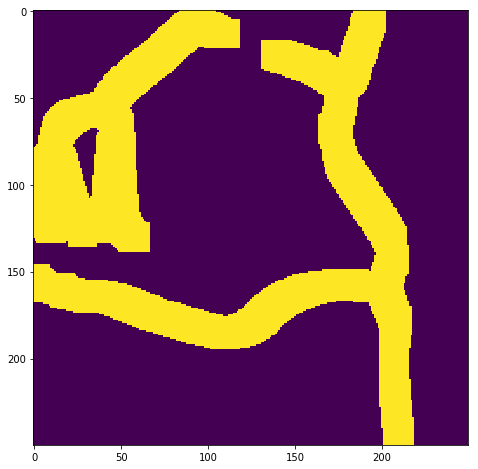

In [64]:
plt.figure(figsize=(10,8))
plt.imshow(skeleton_meta[207][0]) #  101, 

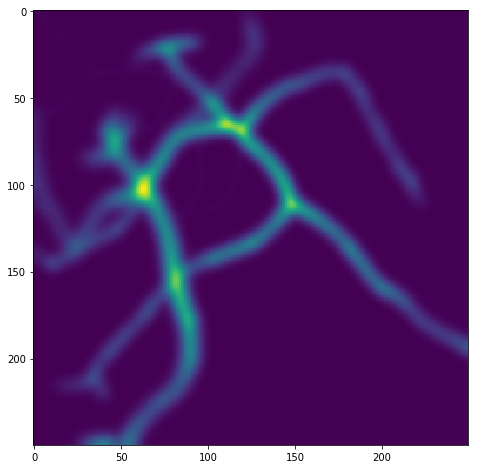

In [71]:
plt.figure(figsize=(10,8))
plt.imshow(skeletons[480][0]) #  207

In [63]:
X = None

for skeleton in skeletons:
    if X is None:
        X = skeleton
    else:
        X = np.concatenate([X, skeleton], axis=0)

In [223]:
writeh5("SK-LARGE-MIX-GAUSSIAN-train.h5", X)

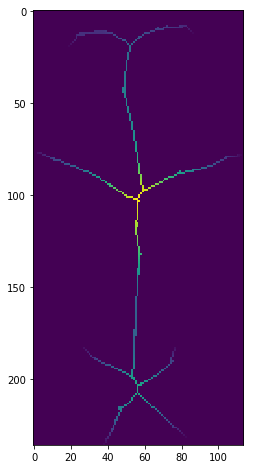

In [59]:
plt.figure(figsize=(10,8))
plt.imshow(skeletons[10])

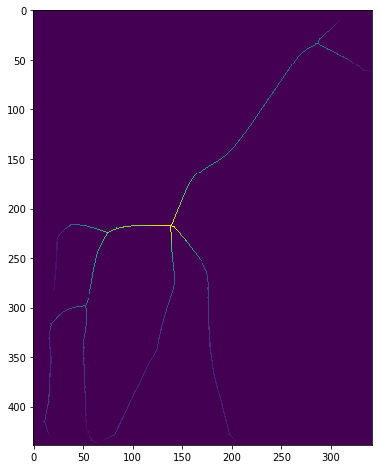

In [73]:
plt.figure(figsize=(10,8))
plt.imshow(skeletons[20])

In [4]:
def readh5(filename, datasetname='main', rr=[1,1,1]):
    fid=h5py.File(filename,'r')
    if isinstance(datasetname, (list,)):
        out = [None] *len(datasetname)
        for i,dd in enumerate(datasetname):
            sz = len(fid[dd].shape)
            if sz==2:
                out[i] = np.array(fid[dd][::rr[0],::rr[1]])
            elif sz==3:
                out[i] = np.array(fid[dd][::rr[0],::rr[1],::rr[2]])
    else:
        sz = len(fid[datasetname].shape)
        if sz==2:
            out = np.array(fid[datasetname][::rr[0],::rr[1]])
        elif sz==3:
            out = np.array(fid[datasetname][::rr[0],::rr[1],::rr[2]])
        elif sz==4:
            out = np.array(fid[datasetname][::,::rr[0],::rr[1],::rr[2]])
    return out


In [5]:
X = readh5("SK-LARGE-MIX-GAUSSIAN-train.h5")
y = readh5("SK-LARGE-MIX-GAUSSIAN-labels.h5")

In [16]:
y.shape

(709, 14610)

In [10]:
X = np.expand_dims(X, axis=3)

In [12]:
INPUT_SHAPE = (622, 639, 1)

In [19]:
model_RN = applications.ResNet50(weights = None, 
                                  include_top = False,
                                  input_shape = INPUT_SHAPE)

x = model_RN.output
x = Flatten()(x)
output_RN = Dense(14610)(x)


ResNet = Model(input = model_RN.input, output = output_RN)
ResNet.compile(loss = "mean_squared_error", optimizer = 'adam', metrics=["accuracy"])

/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [20]:
ResNet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 622, 639, 1)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 628, 645, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 311, 320, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 311, 320, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Read the test image and the predictions

In [23]:
import scipy.io
from scipy import misc

pwd_test = 'SK-LARGE/groundTruth/test/'
pwd_predictions = 'det_SK-LARGE/'


import os

skeletons_test = []
skeletons_prediction = []

directory_test = os.fsencode(pwd_test)
directory_predictions = os.fsencode(pwd_predictions)

for file_test in os.listdir(directory_test):
    filename_test = os.fsdecode(file_test)
    filename = filename_test[:-4]
    filename_pred = filename + ".png"

    mat = scipy.io.loadmat(pwd_test + filename_test)
    skeleton = mat['symmetry']
    skeletons_test.append(skeleton)
    
    skeletons_prediction.append(misc.imread(pwd_predictions + filename_pred))
    

# Infer max shape
max_x, max_y = 256, 256

# Padding each image to the max shape, and create the design matrix
X_test = None
X_pred = None

for i in range(len(skeletons_test)):

    skeleton_test_pad = np.zeros((max_x, max_y))
    skeleton_prediction_pad = np.zeros((max_x, max_y))
    skeleton_test = skeletons_test[i]
    skeleton_prediction = skeletons_prediction[i]
    
    M, N = min(max_x, skeleton_test.shape[0]), min(max_y, skeleton_test.shape[1])
    
    for m in range(M):
        for n in range(N):
            skeleton_test_pad[m][n] = skeleton_test[m][n]
            skeleton_prediction_pad[m][n] = skeleton_prediction[m][n]

    skeleton_test_pad = np.expand_dims(skeleton_test_pad, axis=0)
    skeleton_prediction_pad = np.expand_dims(skeleton_prediction_pad, axis=0)
    
    # Apply gaussian blending to the prediction to make sure that it is continuous
    skeleton_test_pad_gaussian = gaussian_filter(skeleton_test_pad, sigma=[0, 2, 2])
    
    if X_test is None:
        X_test = skeleton_test_pad_gaussian
    if X_pred is None:
        X_pred = skeleton_prediction_pad
    if X_test is not None:
        X_test = np.concatenate([X_test, skeleton_test_pad_gaussian], axis=0)
    if X_pred is not None:
        X_pred = np.concatenate([X_pred, skeleton_prediction_pad], axis=0)

/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


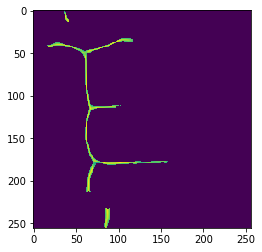

In [107]:
plt.imshow(X_pred[120])

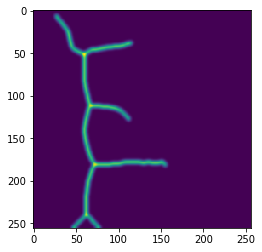

In [108]:
plt.imshow(X_test[120])

In [114]:
np.expand_dims(X_test[0], 0).shape

(1, 256, 256)

In [117]:
import h5py
for i in range(X_pred.shape[0]):
    img = np.expand_dims(X_pred[i], 0)
    writeh5("SK-LARGE-pred/" + str(i) + ".h5", img)

In [111]:
writeh5("SK-LARGE-test.h5", X_test)

In [112]:
writeh5("SK-LARGE-pred.h5", X_pred)